In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [56]:

import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/train.csv",parse_dates=['date'])
test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/test.csv",parse_dates=['date'])

In [57]:
df = pd.concat([train, test], sort=False)

In [58]:
train['date'].max()

Timestamp('2017-12-31 00:00:00')

# **EDA**

In [ ]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


In [ ]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

Train setinin boyutu: (913000, 4)
Test setinin boyutu: (45000, 4)


In [ ]:
df.shape

(958000, 5)

In [ ]:
# info on the distribution
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.5,8.00,10.00,10.00,10.0
item,1.0,3.00,13.00,25.5,38.00,48.00,50.00,50.0
sales,0.0,16.00,30.00,47.0,70.00,107.00,135.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [ ]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

In [ ]:
# more details on sales
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [ ]:
#number of stores
df["store"].nunique()

10

In [ ]:
#number of items 
df["item"].nunique() 

50

In [ ]:
#number of items per store
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
# sales of each store of each item
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

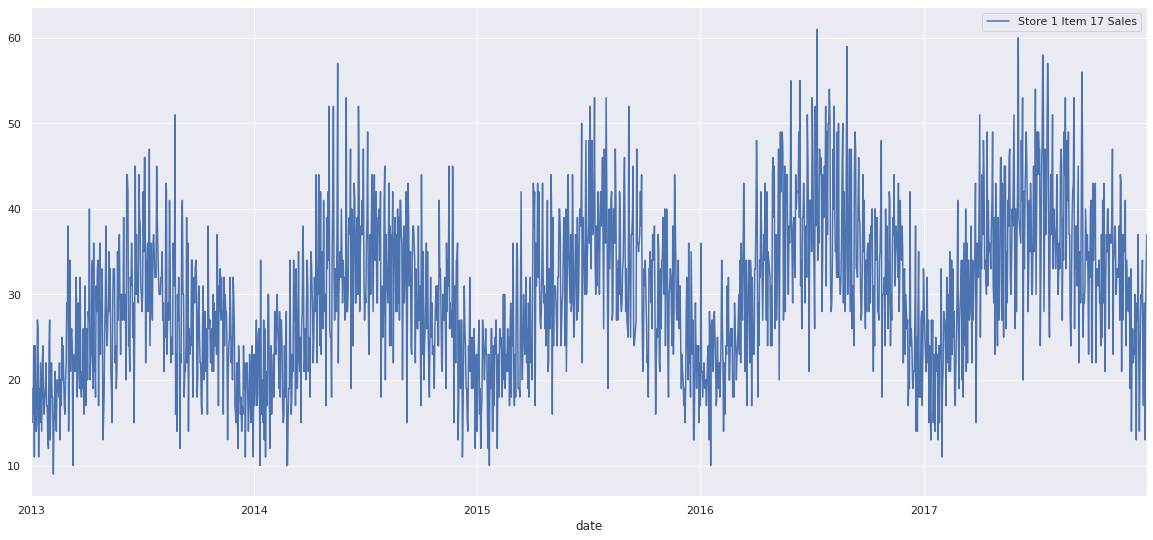

In [59]:
df[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")

# **feature engineering**

In [ ]:
#feature engineering which will help us track and explain different data behaviours or spot patterns
df['month'] = df.date.dt.month

df['day_of_month'] = df.date.dt.day

df['day_of_year'] = df.date.dt.dayofyear 

df['week_of_year'] = df.date.dt.weekofyear

df['day_of_week'] = df.date.dt.dayofweek

df['year'] = df.date.dt.year

df["is_wknd"] = df.date.dt.weekday // 4

df['is_month_start'] = df.date.dt.is_month_start.astype(int)

df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [ ]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [ ]:
#random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [ ]:
#Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [ ]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [ ]:
#Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,37.988844,55.639784,64.456406,69.648348,66.944112,82.407196,81.079507,58.651927,98.741745,71.399262,91.254575,83.723327,82.840980,41.102494,53.993266,66.871500,67.862074,81.979884,112.096892,66.149794,96.496783,72.783196,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,63.104330,49.506655,68.154329,59.202928,75.453305,82.159198,78.846364,73.122770,78.508958,67.086254,84.488963,87.991494,82.900873,62.781025,51.029933,66.998715,60.078621,89.919799,118.930969,60.061498,80.164968,68.047832,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.790664,64.557449,72.156731,64.773251,74.078526,86.619970,83.221303,65.657957,98.832496,75.709768,86.730597,86.153326,82.021172,59.037810,62.880299,71.949987,65.940786,102.869198,119.989310,72.870615,98.811650,74.930478,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,

In [ ]:
#One-Hot Encoding

df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [ ]:
#Converting sales to log(1+sales)

df['sales'] = np.log1p(df["sales"].values)

# **LGBM**

In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
Y_train = train['sales']


X_train = train[cols]


Y_val = val['sales']


X_val = val[cols] 


Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 94), (45000,), (45000, 94))

In [ ]:
#cost function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # custom cost function
                  verbose_eval=2000)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)



[2000]	training's l1: 0.127966	training's SMAPE: 13.1376	valid_1's l1: 0.132285	valid_1's SMAPE: 13.5975
[4000]	training's l1: 0.12654	training's SMAPE: 12.994	valid_1's l1: 0.131467	valid_1's SMAPE: 13.5148
[6000]	training's l1: 0.125701	training's SMAPE: 12.909	valid_1's l1: 0.131176	valid_1's SMAPE: 13.4857
[8000]	training's l1: 0.125	training's SMAPE: 12.8378	valid_1's l1: 0.131058	valid_1's SMAPE: 13.4739
Early stopping, best iteration is:
[9032]	training's l1: 0.124683	training's SMAPE: 12.8055	valid_1's l1: 0.131022	valid_1's SMAPE: 13.4703


In [ ]:
# percentage of validation error
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.470348191333603

In [ ]:
#determination of test and train dependent/independent variables
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

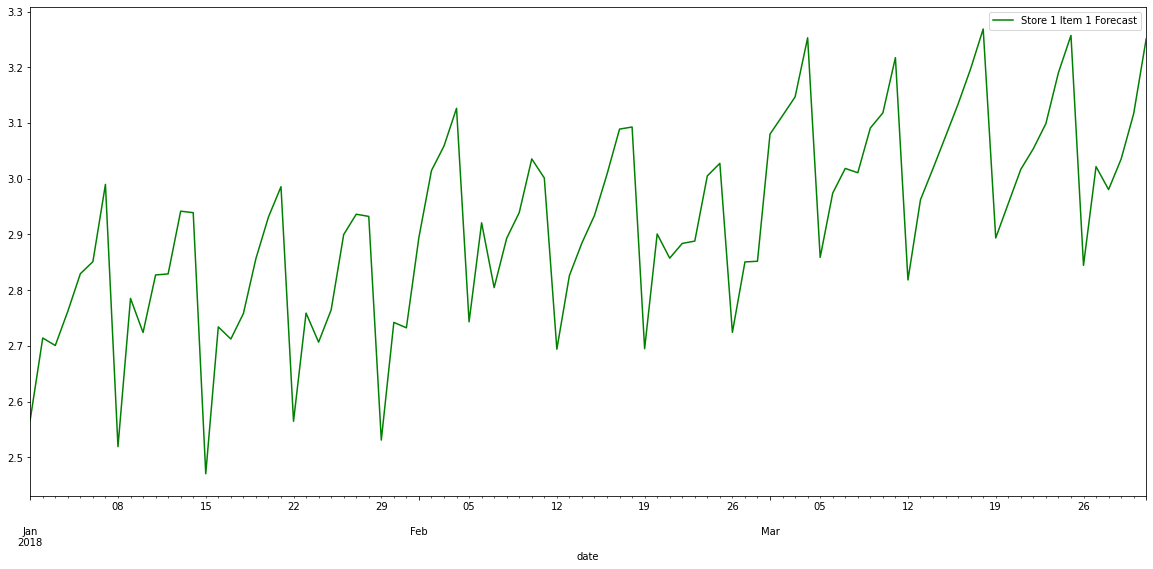

In [ ]:
#estimation of the 1st item of the 1st store
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

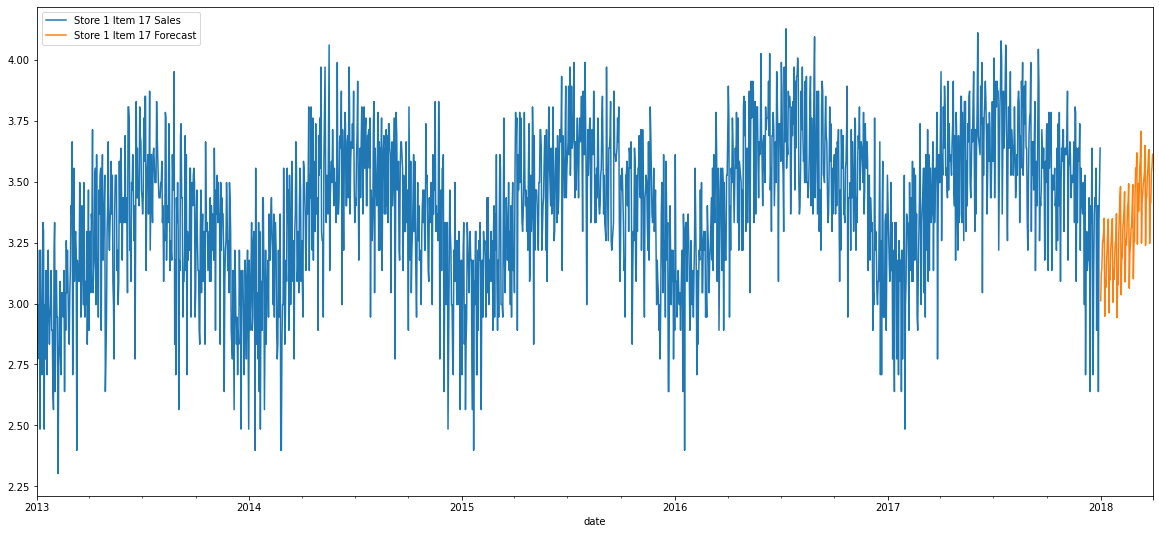

In [ ]:
#estimation of the 17th item of the 1st store
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [ ]:
import joblib
# save model
joblib.dump(model, '/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/LGBM.pkl')

['/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/LGBM.pkl']

In [ ]:
# load model
gbm_pickle = joblib.load('/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/LGBM.pkl')

# **XGBoost**

In [ ]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/train.csv",parse_dates=['date'])
test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/test.csv",parse_dates=['date'])

In [ ]:
df = pd.concat([train, test], sort=False)

In [ ]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

In [ ]:
preds=xboost(X_train, Y_train, X_val)

In [ ]:
# percentage of validation error
smape(np.expm1(preds), np.expm1(Y_val))

3.071625922680639

In [ ]:
test_preds =xboost(X_train, Y_train, X_test)

In [ ]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

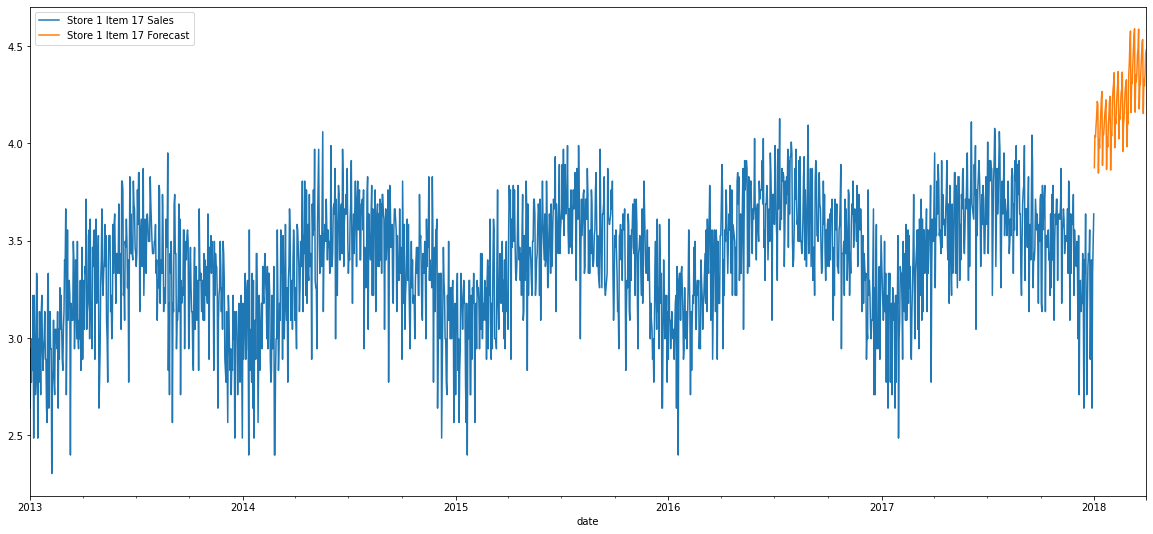

In [ ]:
#estimation of the 17th item of the 1st store
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [ ]:
model_xgb.save_model("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/XGBoost.json")

In [ ]:
model_xgb_2 = xgb.Booster()
model_xgb_2.load_model("model.json")

# **SARIMAX**

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [1]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/train.csv",parse_dates=['date'],index_col='date')
test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/csv/Data Mining/test.csv",parse_dates=['date'],index_col='date')
df = pd.concat([train, test], sort=True)

In [6]:
buf = df[(df.item==17)&(df.store==1)].copy()

<Figure size 432x288 with 0 Axes>

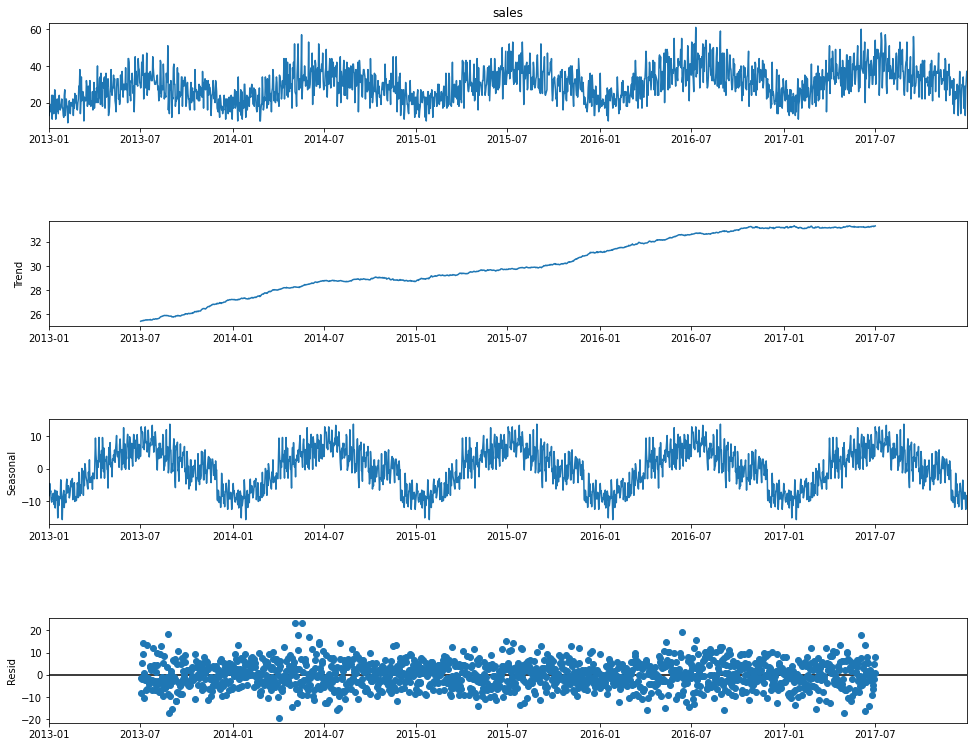

In [7]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(buf.sales.dropna(),freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [8]:
#train_test_split
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

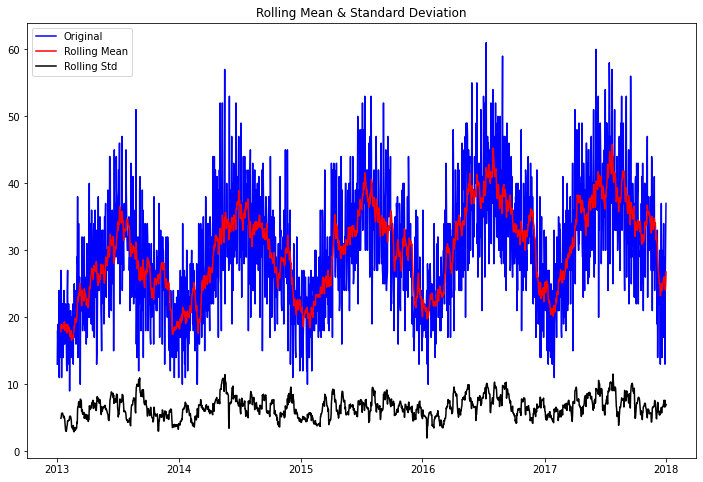

Results of Dickey-Fuller Test:
p-value = 0.0888. The series is likely non-stationary.
Test Statistic                   -2.620646
p-value                           0.088805
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [11]:
test_stationarity(buf['sales'].dropna())

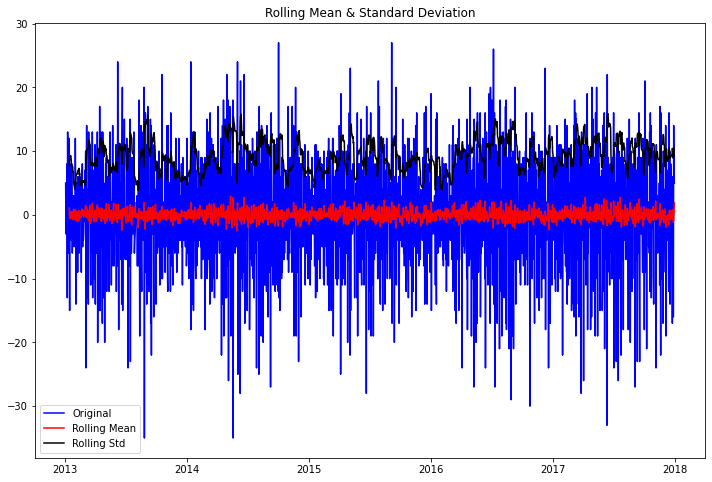

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.556607e+01
p-value                        2.014107e-28
#Lags Used                     1.900000e+01
Number of Observations Used    1.805000e+03
Critical Value (1%)           -3.433978e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567623e+00
dtype: float64


In [12]:
test_stationarity(buf['sales'].diff().dropna())

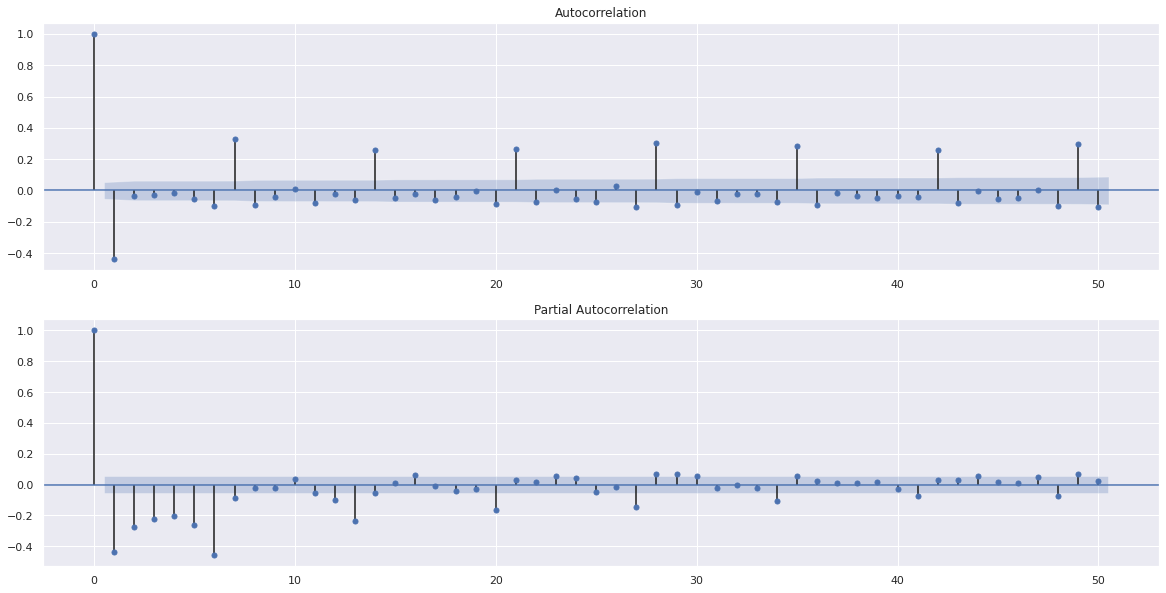

In [15]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [16]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


In [18]:
month_dummies

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
date,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,0,1,0,0,0,0,0,0,0,0,0
2018-03-28,0,0,1,0,0,0,0,0,0,0,0,0
2018-03-29,0,0,1,0,0,0,0,0,0,0,0,0


In [33]:
buf = df[(df.item==17)&(df.store==1)].copy()#reset buf
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
buf = pd.merge(buf,month_dummies, how='inner', left_index=True, right_index=True).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf =pd.merge(buf,week_dummies, how='inner', left_index=True, right_index=True).drop(['dayofweek'],axis=1)
#Satday,Sunday
buf['weekend'] = (buf.index.dayofweek>4).astype(int)#Satday,Sunday
#Sunday
#buf['sunday'] = (buf.index.dayofweek==6).astype(int)#Satday,Sunday

In [36]:
#shifted data
#buf['sales_shifted_91'] = buf.sales.shift(91)
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)
buf.drop('id',axis=1,inplace=True)

In [55]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [39]:
arimax_2 = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
arimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3144.711
Date:                Mon, 31 Oct 2022   AIC                           6363.423
Time:                        09:55:28   BIC                           6544.824
Sample:                    01-01-2015   HQIC                          6432.385
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -8.4237      1.406     -5.992      0.000     -11.179      -5.668
month-2              -5.8344      1.347     -4.331      0.000      -8.474      -3.194
month-3              -2.5022      1.195     -2.094      0.036      -4.844      -0.160
month-4               3.0957      1.143      2.708      0.007       0.855       5.336
month-5               3.9035      1.144      3.412      0.001       1.661       6.146
month-6               4.0917      1.144      3.575      0.000       1.849       6.335
month-7               5.9638      1.210      4.930      0.000       3.593       8.335
month-8              -0.1234      1.377     -0.090      0.929      -2.823       2.576
month-9              -0.8413      1.396     -0.603      0.547      -3.578       1.895
month-10              0.6543      1.341      0.488      0.626      -1.975       3.283
month-11              5.0398      1.455      3.464      0.001       2.188       7.891
month-12             -5.0238      1.559     -3.222      0.001      -8.080      -1.968
dayofweek-0          -4.9182      0.612     -8.037      0.000      -6.118      -3.719
dayofweek-1          -1.4856      0.503     -2.952      0.003      -2.472      -0.499
dayofweek-2          -0.8136      0.508     -1.602      0.109      -1.809       0.181
dayofweek-3           0.1974      0.527      0.375      0.708      -0.836       1.230
dayofweek-4           3.4116      0.512      6.669      0.000       2.409       4.414
dayofweek-5           0.9556      0.398      2.401      0.016       0.175       1.736
dayofweek-6           2.6526      0.400      6.638      0.000       1.869       3.436
weekend               3.6082      0.361      9.998      0.000       2.901       4.316
sales_shifted_728     0.0327      0.035      0.927      0.354      -0.036       0.102
sales_shifted_364     0.0056      0.035      0.160      0.873      -0.062       0.073
ar.L1                -0.9617      0.787     -1.222      0.222      -2.504       0.581
ar.L2                -0.5553      0.757     -0.733      0.463      -2.039       0.929
ar.L3                -0.6451      0.479     -1.347      0.178      -1.583       0.293
ar.L4                -0.8592      0.541     -1.589      0.112      -1.919       0.201
ar.L5                -0.7380      0.680     -1.086      0.278      -2.070       0.594
ar.L6                -0.0726      0.630     -0.115      0.908      -1.307       1.162
ar.L7                -0.0506      0.083     -0.612      0.541      -0.213       0.112
ma.L1                 0.0262      0.790      0.033      0.974      -1.523       1.575
ma.L2                -0.3567      0.122     -2.933      0.003      -0.595      -0.118
ma.L3                 0.1001      0.256      0.391      0.696      -0.402       0.602
ma.L4                 0.2823      0.142      1.988      0.047       0.004       0.561
ma.L5                -0.1025      0.225     -0.455      0.649      -0.544       0.339
ma.L6                -0.6824      0.111     -6.150      0.0

In [40]:
from sklearn.metrics import mean_squared_error
pred = arimax_2.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:50.91462498287481


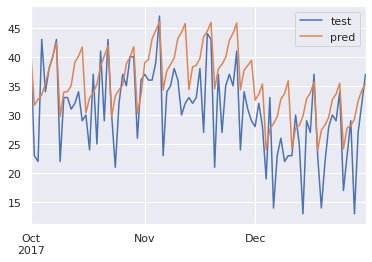

In [41]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

In [45]:
tr_start,tr_end = '2015-01-01','2017-12-31'
te_start,te_end = '2018-01-01','2018-03-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [48]:
arimax_2 = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
arimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1096
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3437.508
Date:                Mon, 31 Oct 2022   AIC                           6949.015
Time:                        10:14:06   BIC                           7133.689
Sample:                    01-01-2015   HQIC                          7018.919
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1             -10.3089      1.380     -7.470      0.000     -13.014      -7.604
month-2              -4.9497      1.387     -3.569      0.000      -7.668      -2.231
month-3              -1.3696      1.290     -1.062      0.288      -3.898       1.159
month-4               1.8060      1.212      1.491      0.136      -0.569       4.181
month-5               4.6958      1.223      3.838      0.000       2.298       7.094
month-6               5.9575      1.195      4.986      0.000       3.615       8.299
month-7               5.2771      1.225      4.306      0.000       2.875       7.679
month-8               0.0858      1.361      0.063      0.950      -2.582       2.754
month-9              -0.9936      1.378     -0.721      0.471      -3.693       1.706
month-10              0.6625      1.276      0.519      0.604      -1.839       3.164
month-11              3.6991      1.379      2.682      0.007       0.996       6.402
month-12             -4.5619      1.487     -3.068      0.002      -7.477      -1.647
dayofweek-0          -5.1993      0.532     -9.768      0.000      -6.243      -4.156
dayofweek-1          -1.5155      0.432     -3.504      0.000      -2.363      -0.668
dayofweek-2          -0.7631      0.446     -1.711      0.087      -1.637       0.111
dayofweek-3           0.0879      0.448      0.196      0.844      -0.790       0.966
dayofweek-4           3.4861      0.448      7.790      0.000       2.609       4.363
dayofweek-5           0.9617      0.348      2.764      0.006       0.280       1.644
dayofweek-6           2.9423      0.354      8.313      0.000       2.249       3.636
weekend               3.9039      0.308     12.657      0.000       3.299       4.508
sales_shifted_728     0.0096      0.033      0.292      0.770      -0.055       0.074
sales_shifted_364    -0.0060      0.033     -0.182      0.856      -0.070       0.058
ar.L1                -0.9002      1.283     -0.702      0.483      -3.415       1.615
ar.L2                -0.7733      0.770     -1.005      0.315      -2.282       0.735
ar.L3                -0.6528      0.890     -0.733      0.463      -2.398       1.092
ar.L4                -1.1186      0.552     -2.028      0.043      -2.200      -0.037
ar.L5                -0.7053      1.325     -0.532      0.594      -3.302       1.891
ar.L6                -0.0840      0.557     -0.151      0.880      -1.176       1.008
ar.L7                -0.0412      0.091     -0.454      0.650      -0.219       0.137
ma.L1                -0.0122      1.283     -0.009      0.992      -2.527       2.503
ma.L2                -0.0648      0.664     -0.098      0.922      -1.366       1.236
ma.L3                -0.0889      0.407     -0.218      0.827      -0.887       0.709
ma.L4                 0.5581      0.382      1.460      0.144      -0.191       1.307
ma.L5                -0.3380      0.931     -0.363      0.717      -2.163       1.487
ma.L6                -0.6323      0.925     -0.684      0.4

In [49]:

test_preds = arimax_2.predict(tr_end,te_end,exog = exog_test)[:]

In [51]:
forecast = pd.DataFrame({
                        "sales":test_preds
                        })

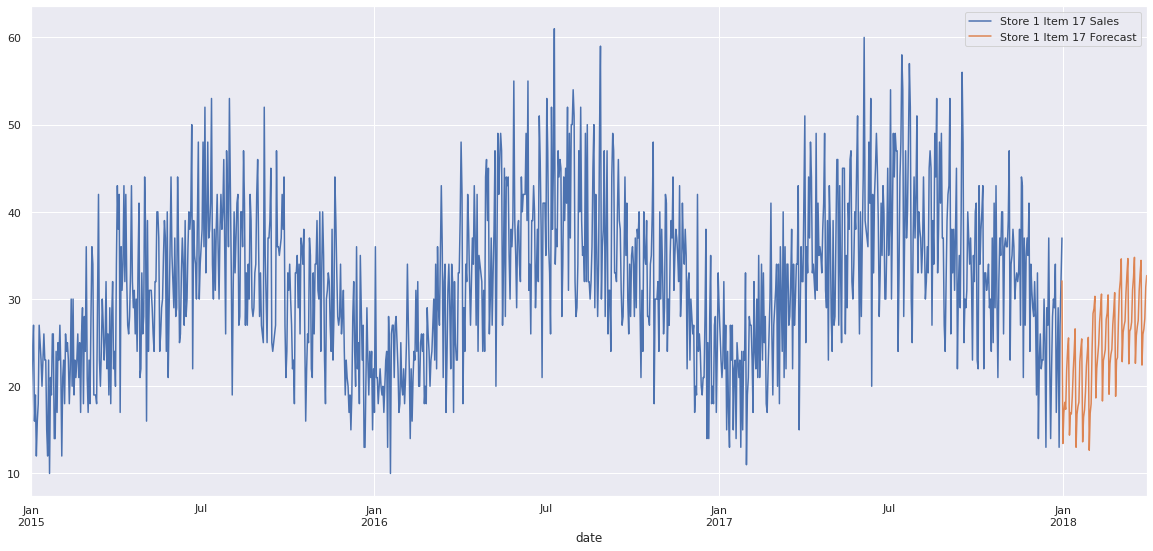

In [54]:
#estimation of the 17th item of the 1st store
buf['sales'][tr_start:tr_end].plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast.sales.plot(legend=True, label = "Store 1 Item 17 Forecast");